# Determining the age of buyers
A  supermarket chain introduces a computer vision system for processing customers' photos. Photo fixation in the checkout area will help determine the age of customers in order to:
- Analyze purchases and offer products that may be of interest to buyers of this age group;
- Control the conscientiousness of cashiers when selling alcohol.

Build a model that will determine the approximate age of a person from a photograph. At your disposal is a set of photographs of people with age indication.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploratory-data-analysis" data-toc-modified-id="Exploratory-data-analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploratory data analysis</a></span><ul class="toc-item"><li><span><a href="#Conclusion:" data-toc-modified-id="Conclusion:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Conclusion:</a></span></li></ul></li><li><span><a href="#Model-training" data-toc-modified-id="Model-training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model training</a></span></li><li><span><a href="#Analysis-of-the-trained-model" data-toc-modified-id="Analysis-of-the-trained-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analysis of the trained model</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,  Flatten, Conv2D, AvgPool2D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Exploratory data analysis
Let's load the data.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
    
train_datagen = datagen.flow_from_dataframe(dataframe=labels,
                                           directory='/datasets/faces/final_files',
                                           x_col='file_name',
                                           y_col='real_age',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='raw',
                                           seed=12345)    

Found 7591 validated image filenames.


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

<AxesSubplot:>

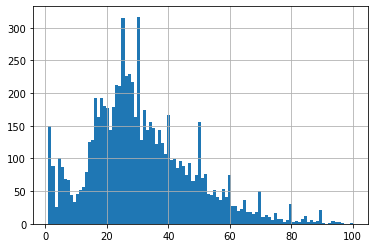

In [3]:
display(labels.head())

display(labels.real_age.describe())
labels.real_age.hist(bins=100)

There are outliers every 5 years. Probably the data were not scaled precisely. 
Let us take a look at the photos:

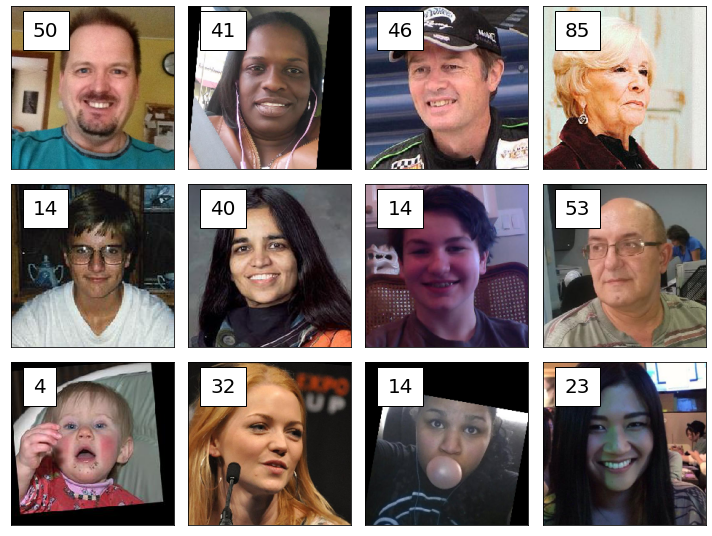

In [4]:
sample_pic, sample_age = next(train_datagen)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i + 1)

    plt.imshow(sample_pic[i])
    plt.text(30, 40, sample_age[i], fontsize=20, bbox={'facecolor': 'white', 'pad': 10})
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Conclusion:
- There are 7591 photos in the dataset. The largest number of people are aged 15-40 years. The model may give a small error if the predicted values are in this range.
- Among the photos there are both color and black-white. Some have black frames. In some of the photographs, people have their eyes closed. This can affect model predictions.
- In some photographs, people's faces are turned to the right, in some - to the left. It makes sense to consider augmentation with horizontal flip of photographs.

## Model training
Functions used to work on GPU:


```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, 
                                 horizontal_flip=True, 
                                 rescale=1/255.)
    train_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                directory=path + 'final_files',
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='raw',
                                                subset='training',
                                                seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1 / 255.)
    test_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                     directory=path + 'final_files/',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     class_mode='raw',
                                                     subset='validation',
                                                     seed=12345)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(
                        input_shape=(224, 224, 3),
                        # weights='imagenet',
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    optimizer = Adam(lr=0.0001)
    model = Sequential()

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, input_dim=None, activation='relu'))

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae']) #
    return model

def train_model(model, train_data, test_data, epochs=5, batch_size=None,  steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              epochs=epochs,
              batch_size=batch_size,
              verbose=2,    
              steps_per_epoch=steps_per_epoch,
              validation_data=test_data,
              shuffle=True,
              validation_steps=validation_steps
             )
    return model


```

**Output:**

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 73s - loss: 263.6664 - mae: 11.4248 - val_loss: 1023.5641 - val_mae: 27.3251
Epoch 2/10
178/178 - 40s - loss: 78.3630 - mae: 6.6600 - val_loss: 792.4299 - val_mae: 23.1010
Epoch 3/10
178/178 - 39s - loss: 49.0608 - mae: 5.3346 - val_loss: 228.8025 - val_mae: 11.1232
Epoch 4/10
178/178 - 39s - loss: 36.5096 - mae: 4.6035 - val_loss: 140.2549 - val_mae: 8.8552
Epoch 5/10
178/178 - 39s - loss: 28.6676 - mae: 4.0664 - val_loss: 80.6548 - val_mae: 6.7560
Epoch 6/10
178/178 - 39s - loss: 21.7717 - mae: 3.5630 - val_loss: 83.6759 - val_mae: 7.1605
Epoch 7/10
178/178 - 39s - loss: 17.3221 - mae: 3.1966 - val_loss: 67.6493 - val_mae: 6.3543
Epoch 8/10
178/178 - 39s - loss: 15.5274 - mae: 3.0384 - val_loss: 64.6343 - val_mae: 6.0316
Epoch 9/10
178/178 - 39s - loss: 13.5737 - mae: 2.8062 - val_loss: 68.0514 - val_mae: 6.2781
Epoch 10/10
178/178 - 39s - loss: 11.8589 - mae: 2.6111 - val_loss: 66.0985 - val_mae: 6.0689

Test MAE: 6.0689
```


## Analysis of the trained model
We considere a dataset with photographs of people and their age was considered as a target feature. Using a neural network (Resnet with 50 layers, GlobalAveragePooling2D and densely connected layers, optimization method - Adam) we obtained the value of the quality metric MAE = 3.0 on the training data and MAE = 6.0 on the validation set. We can say that the trained model gives an age prediction accuracy of ± 6.0 years.

To offer goods to people of a certain age category, the constructed model can work well if the age is broken down into intervals of >12 years. In order to predict age to control the conscientiousness of cashiers when selling alcohol, this model will not work well, because it may overestimate the age of minors.